In [1]:
import numpy as np
from scipy import stats
import scipy.stats
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro

# 회귀분석
from statsmodels.formula.api import ols
# qqplot, 회귀분석의 상수항 추가
from statsmodels.api import qqplot, add_constant
# 선형 모델 formula(y~X1+X2+...)
import statsmodels.formula.api as smf
# Scaling 클래스
from sklearn.preprocessing import scale, minmax_scale, robust_scale


# jupyter notebook 사용 시 그래프 자동 출력 옵션
# matplotlib 이용한 Background 그래프 실행 및 결과 확인
%matplotlib inline

# 음수 표시
plt.rc('axes', unicode_minus=False)
# 맑은 고딕 적용
plt.rc("font", family="Malgun Gothic")

# 데이터 정제

### 1.
아래는 운동에 따른 혈당 산소 요구량 데이터이다.  
결측치 미 이상치를 확인하고 적절한 방법으로 처리하시오.  
(결측치 처리 변수 : GENDER, WEIGHT, 이상치 처리 변수 : RSTPULSE)
- 데이터 : FITNESS_결측.CSV (변수 : 10개, 자료 수 : 31개)

In [2]:
# engine: 파일명 또는 데이터에 한글 포함 -> "python" 사용
df_raw=pd.read_csv("../data/FITNESS_결측.csv", engine="python")
df_raw.head()

,NAME,GENDER,AGE,AGEGROUP,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
0,Donna,여성,42,40대,68.15,59.571,8.17,166,40,172
1,Gracie,NaN,38,30대,81.87,60.055,8.63,170,48,186
2,Luanne,여성,43,40대,85.84,54.297,8.65,156,45,168
3,Mimi,여성,50,50대,70.87,54.625,8.92,146,48,155
4,Chris,남성,49,40대,NaN,49.156,8.95,180,44,185


In [3]:
# 결측치 확인 : pandas.DataFrame.isnull() 또는 pandas.DataFrame.isna()
df_raw.isnull().head()

,NAME,GENDER,AGE,AGEGROUP,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
0,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False


In [4]:
# isnull()과 동일
df_raw.isna().head()

,NAME,GENDER,AGE,AGEGROUP,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
0,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False


In [5]:
# 결측치(True) 현황 요약 : sum 함수
df_raw.isnull().sum()

NAME        0
GENDER      1
AGE         0
AGEGROUP    0
WEIGHT      2
OXY         0
RUNTIME     0
RUNPULSE    0
RSTPULSE    0
MAXPULSE    0
dtype: int64

In [6]:
# 문자형 결측치 처리 : pandas.DataFrame;fillna(값, inplace : 결측치 입력 후 저장 여부)
df_raw["GENDER"].fillna("여성", inplace=True)
df_raw.head()

,NAME,GENDER,AGE,AGEGROUP,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
0,Donna,여성,42,40대,68.15,59.571,8.17,166,40,172
1,Gracie,여성,38,30대,81.87,60.055,8.63,170,48,186
2,Luanne,여성,43,40대,85.84,54.297,8.65,156,45,168
3,Mimi,여성,50,50대,70.87,54.625,8.92,146,48,155
4,Chris,남성,49,40대,NaN,49.156,8.95,180,44,185


In [7]:
# 숫자형 결측치 처리 : groupby(범주형 변수),agg("집계함수")
df_raw.groupby("GENDER")["WEIGHT"].agg("mean")

GENDER
남성    82.433077
여성    72.908750
Name: WEIGHT, dtype: float64

In [8]:
# 숫자형 결측치 처리 : transform("집계함수")
# 코드가 길어 행 바꿈 필요시 \(won 표시) 끝에 추가
df_raw["WEIGHT"]=df_raw["WEIGHT"].fillna(df_raw.groupby("GENDER")["WEIGHT"].transform("mean")).round(3)
df_raw.head()

,NAME,GENDER,AGE,AGEGROUP,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
0,Donna,여성,42,40대,68.150,59.571,8.17,166,40,172
1,Gracie,여성,38,30대,81.870,60.055,8.63,170,48,186
2,Luanne,여성,43,40대,85.840,54.297,8.65,156,45,168
3,Mimi,여성,50,50대,70.870,54.625,8.92,146,48,155
4,Chris,남성,49,40대,82.433,49.156,8.95,180,44,185


<AxesSubplot:>

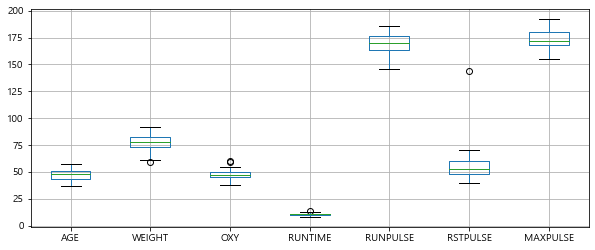

In [9]:
# boxplot : 상자수염도, figsize : 그래프 크기(x축, y축)
df_raw.boxplot(figsize=(10, 4))

In [10]:
# RSTPULSE 변수에서 이상치(100보다 큰 값) 확인 : True/False 표시
df_raw["RSTPULSE"]>=100

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28     True
29    False
30    False
Name: RSTPULSE, dtype: bool

In [11]:
df_raw.loc[27:29]

,NAME,GENDER,AGE,AGEGROUP,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
27,Mark,남성,57,50대,73.37,39.407,12.63,174,58,176
28,Steve,남성,54,50대,91.63,39.203,12.88,168,144,172
29,Vaughn,남성,44,40대,81.42,39.442,13.08,174,63,176


In [12]:
# 조건 해당 자료 직접 확인
df_raw[(df_raw["RSTPULSE"]>=100)]
# 복수 조건 : &(and), |(or)
# df_raw[(df_raw["RSTPULSE"]>=100)&(df_raw["GENDER"]=="남성")]

,NAME,GENDER,AGE,AGEGROUP,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
28,Steve,남성,54,50대,91.63,39.203,12.88,168,144,172


In [13]:
# RSTPULSE 변수에서 이상치 제외(100 이하)
df_fitness=df_raw[df_raw["RSTPULSE"]<100]
df_fitness # 자료 수가 줄어듦

,NAME,GENDER,AGE,AGEGROUP,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
0,Donna,여성,42,40대,68.150,59.571,8.17,166,40,172
1,Gracie,여성,38,30대,81.870,60.055,8.63,170,48,186
2,Luanne,여성,43,40대,85.840,54.297,8.65,156,45,168
3,Mimi,여성,50,50대,70.870,54.625,8.92,146,48,155
4,Chris,남성,49,40대,82.433,49.156,8.95,180,44,185
5,Allen,남성,38,30대,89.020,49.874,9.22,178,55,180
6,Nancy,여성,49,40대,76.320,48.673,9.40,186,56,188
7,Patty,여성,52,50대,76.320,45.441,9.63,164,48,166
8,Suzanne,여성,57,50대,59.080,50.545,9.93,148,49,155
9,Teresa,여성,51,50대,77.910,46.672,10.00,162,48,168


In [14]:
# 자료 index reset : DataFrame.reset_index
df_fitness.reset_index(drop=True, inplace=True)
df_fitness

,NAME,GENDER,AGE,AGEGROUP,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
0,Donna,여성,42,40대,68.150,59.571,8.17,166,40,172
1,Gracie,여성,38,30대,81.870,60.055,8.63,170,48,186
2,Luanne,여성,43,40대,85.840,54.297,8.65,156,45,168
3,Mimi,여성,50,50대,70.870,54.625,8.92,146,48,155
4,Chris,남성,49,40대,82.433,49.156,8.95,180,44,185
5,Allen,남성,38,30대,89.020,49.874,9.22,178,55,180
6,Nancy,여성,49,40대,76.320,48.673,9.40,186,56,188
7,Patty,여성,52,50대,76.320,45.441,9.63,164,48,166
8,Suzanne,여성,57,50대,59.080,50.545,9.93,148,49,155
9,Teresa,여성,51,50대,77.910,46.672,10.00,162,48,168


In [15]:
# select_dtypes 조건으로 변수 유형 선택 : select_dtypes="object" - 문자형 변수
# 숫자형 변수 선택 : select_dtypes="object" 제외
df_fitness_num=df_fitness.select_dtypes(exclude="object")
df_fitness_num.head()

,AGE,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
0,42,68.150,59.571,8.17,166,40,172
1,38,81.870,60.055,8.63,170,48,186
2,43,85.840,54.297,8.65,156,45,168
3,50,70.870,54.625,8.92,146,48,155
4,49,82.433,49.156,8.95,180,44,185


In [16]:
# 문자형 변수 선택 : select_dtypes="object" 선택
df_fitness_char = df_fitness.select_dtypes(include = "object")
df_fitness_char.head()

,NAME,GENDER,AGEGROUP
0,Donna,여성,40대
1,Gracie,여성,30대
2,Luanne,여성,40대
3,Mimi,여성,50대
4,Chris,남성,40대


In [17]:
# scale 변환 : 평균, 표준편차 기준
df_scale_std = scale(df_fitness_num)
# scale 적용/변환하면 numpy의 ndarray 형태로 저장 -> DataFrame으로 변환
df_scale_std=pd.DataFrame(df_scale_std, columns=df_fitness_num.columns)
df_scale_std.head()

,AGE,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
0,-0.805985,-1.119445,2.334717,-1.771826,-0.361066,-1.856653,-0.200185
1,-1.506841,0.606869,2.429494,-1.423469,0.029276,-0.777726,1.328503
2,-0.630771,1.106393,1.301962,-1.408323,-1.336919,-1.182324,-0.636953
3,0.595728,-0.777202,1.366191,-1.203852,-2.312773,-0.777726,-2.056450
4,0.420514,0.677708,0.295251,-1.181133,1.005129,-1.317190,1.219311


In [18]:
# scale 변환 결과 확인 : 요약통계량 : pandas.DataFrame.describe()
df_scale_desc = df_scale_std.describe()
df_scale_desc.round(3)

,AGE,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
count,30.000,30.000,30.000,30.000,30.000,30.000,30.000
mean,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000
std,1.017,1.017,1.017,1.017,1.017,1.017,1.017
min,-1.682,-2.261,-2.009,-1.772,-2.313,-1.857,-2.056
25%,-0.631,-0.495,-0.486,-0.609,-0.703,-0.778,-0.637
50%,0.158,-0.020,-0.122,-0.083,0.029,-0.171,-0.200
75%,0.771,0.678,0.511,0.491,0.615,0.672,0.673
max,1.822,1.835,2.429,2.666,1.591,2.189,1.984


In [19]:
# scale 변환 : 최소, 최대값 기준
df_scale_minmax=minmax_scale(df_fitness_num)
# scale 적용/변환하면 numpy의 ndarray 형태로 저장 -> DataFrame으로 변환
df_scale_minmax=pd.DataFrame(df_scale_minmax, columns=df_fitness_num.columns)
df_scale_minmax.head()

,AGE,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
0,0.25,0.278648,0.978647,0.000000,0.50,0.000000,0.459459
1,0.05,0.700154,1.000000,0.078498,0.60,0.266667,0.837838
2,0.30,0.822120,0.745974,0.081911,0.25,0.166667,0.351351
3,0.65,0.362212,0.760445,0.127986,0.00,0.266667,0.000000
4,0.60,0.717450,0.519169,0.133106,0.85,0.133333,0.810811


In [20]:
# scale 변환 결과 확인 : 요약통계량 : pandas.DataFrame.describe()
df_scale_desc=df_scale_minmax.describe()
df_scale_desc.round(3)

,AGE,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
count,30.000,30.000,30.000,30.000,30.000,30.000,30.000
mean,0.480,0.552,0.453,0.399,0.592,0.459,0.509
std,0.290,0.248,0.229,0.229,0.261,0.251,0.252
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.300,0.431,0.343,0.262,0.412,0.267,0.351
50%,0.525,0.547,0.425,0.381,0.600,0.417,0.459
75%,0.700,0.717,0.568,0.510,0.750,0.625,0.676
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [21]:
# sclae 변환 : 로버스트 기준
df_scale_robust = robust_scale(df_fitness_num)
# scale 적용/변환하면 numpy의 ndarray 형태로 저장 -> DataFrame으로 변환
df_scale_robust=pd.DataFrame(df_scale_robust, columns=df_fitness_num.columns)
df_scale_robust.head()

,AGE,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
0,-0.6875,-0.937433,2.463797,-1.535284,-0.296296,-1.162791,0.000000
1,-1.1875,0.534986,2.558834,-1.218589,0.000000,-0.418605,1.166667
2,-0.5625,0.961043,1.428207,-1.204819,-1.037037,-0.697674,-0.333333
3,0.3125,-0.645525,1.492612,-1.018933,-1.777778,-0.418605,-1.416667
4,0.1875,0.595407,0.418733,-0.998279,0.740741,-0.790698,1.083333


In [22]:
# scale 변환 결과 확인 : 요약통계량 : pandas.DataFrame.describe()
df_scale_desc=df_scale_robust.describe()
df_scale_desc.round(3)

,AGE,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
count,30.000,30.000,30.000,30.000,30.000,30.000,30.000
mean,-0.112,0.017,0.123,0.076,-0.022,0.118,0.153
std,0.726,0.868,1.020,0.925,0.772,0.702,0.776
min,-1.312,-1.911,-1.892,-1.535,-1.778,-1.163,-1.417
25%,-0.562,-0.405,-0.365,-0.478,-0.556,-0.419,-0.333
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.438,0.595,0.635,0.522,0.444,0.581,0.667
max,1.188,1.582,2.559,2.499,1.185,1.628,1.667


In [23]:
df_rstpulse=pd.DataFrame()
df_rstpulse["Raw"]=df_fitness_num["RSTPULSE"] # df_fitness 사용 가능 (동일)
df_rstpulse["Standard"]=df_scale_std["RSTPULSE"]
df_rstpulse["MinMax"]=df_scale_minmax["RSTPULSE"]
df_rstpulse["Robust"]=df_scale_robust["RSTPULSE"]
df_rstpulse.head().round(3)

,Raw,Standard,MinMax,Robust
0,40,-1.857,0.000,-1.163
1,48,-0.778,0.267,-0.419
2,45,-1.182,0.167,-0.698
3,48,-0.778,0.267,-0.419
4,44,-1.317,0.133,-0.791


In [24]:
df_rstpulse.describe().round(3)

,Raw,Standard,MinMax,Robust
count,30.000,30.000,30.000,30.000
mean,53.767,0.000,0.459,0.118
std,7.542,1.017,0.251,0.702
min,40.000,-1.857,0.000,-1.163
25%,48.000,-0.778,0.267,-0.419
50%,52.500,-0.171,0.417,0.000
75%,58.750,0.672,0.625,0.581
max,70.000,2.189,1.000,1.628


array([[<AxesSubplot:title={'center':'Raw'}>,
        <AxesSubplot:title={'center':'Standard'}>],
       [<AxesSubplot:title={'center':'MinMax'}>,
        <AxesSubplot:title={'center':'Robust'}>]], dtype=object)

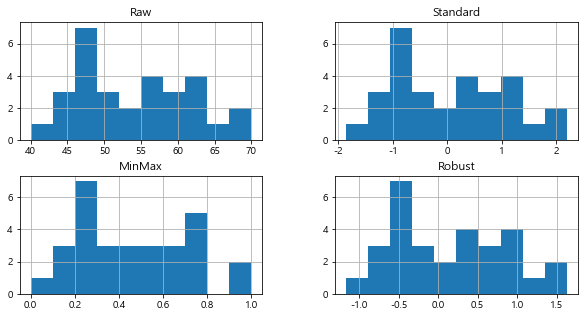

In [25]:
# pandas의 DataFram.hist 이용(figsize = (x축 크기, y축 크기))
df_rstpulse[["Raw", "Standard", "MinMax", "Robust"]].hist(figsize=(10, 5))

# 그래프 분석

In [26]:
# FITNESS.CSV 데이터 가져오기
df_fitness=pd.read_csv("../data/FITNESS.CSV", engine="python")
df_fitness.head()

,NAME,GENDER,AGE,AGEGROUP,WEIGHT,OXY,RUNTIME,RUNPULSE,RSTPULSE,MAXPULSE
0,Donna,여성,42,40대,68.15,59.571,8.17,166,40,172
1,Gracie,여성,38,30대,81.87,60.055,8.63,170,48,186
2,Luanne,여성,43,40대,85.84,54.297,8.65,156,45,168
3,Mimi,여성,50,50대,70.87,54.625,8.92,146,48,155
4,Chris,남성,49,40대,81.42,49.156,8.95,180,44,185


### 2. Bar Chart
아래는 운동에 따른 혈당 산소 요구량 데이터이다.  
성별(GENDER), 연령대(AGEGROUP), 성별(GENDER) + 연령대(AGEGROUP)별로 Bar Chart를 그리고 결과를 해석하시오.  
- 데이터 : FITNESS.CSV(변수 : 10개, 자료 수 : 31개)

<BarContainer object of 2 artists>

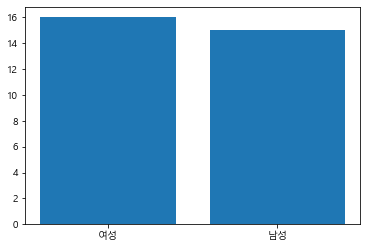

In [59]:
df_count
plt.bar(df_count.index, df_count.values)

<AxesSubplot:>

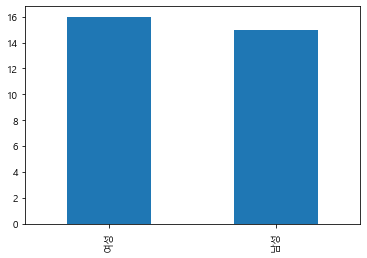

In [56]:
# DataFrame["변수"].value_counts() : 개별(1개) 범주형 변수의 자료 수 계산
# 성별 Bar Chart
df_count = df_fitness["GENDER"].value_counts()
df_count.plot.bar()

<AxesSubplot:>

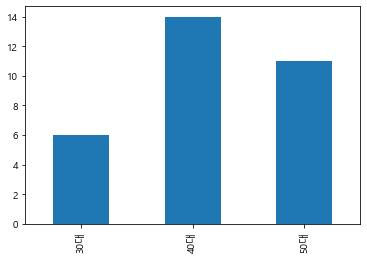

In [28]:
# 연령대 Bar Chart
df_count=df_fitness["AGEGROUP"].value_counts()
# sort_index(inplace=True) : 정렬 결과를 저장
df_count.sort_index(inplace=True)
df_count.plot.bar()

<AxesSubplot:xlabel='GENDER,AGEGROUP'>

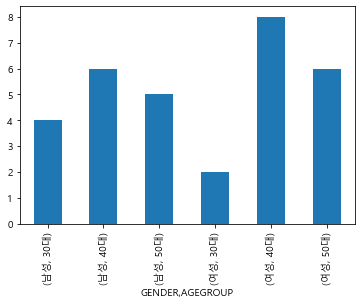

In [29]:
# DataFrame.groupby["변수1", ...].size() : 복수(1개 이상)의 범주형 변수의 자료 수 통합 계산
# 성별 + 연령대 Bar Chart
# groupby(column) : column 기준 자료 요약, as_index : groupby 변수의 index로 사용 여부
df_groupby_total= df_fitness.groupby(["GENDER", "AGEGROUP"], as_index=True).size()
# df_groupby_total=df_fitness.groupby(["GENDER", "AGEGROUP"], as_index=False).agg("count") 위와 동일
df_groupby_total.plot.bar()

 > __성별 : 여성이 남성보다 빈도가 많으나 큰 차이는 없음__  
 > __연령대 : [40대] 자료의 빈도가 가장 많고 [30대]가 가장 적음__  
 > __성별 + 연령대 : (여성, 40대)가 빈도 가장 많고 (여성, 30대)가 가장 적음__   

### 3. Histogram
아래는 운동에 따른 혈당 산소 요구량 데이터이다.  
Histogram을 그리고 결과를 해석하시오.  
- 데이터 : FITNESS.CSV(변수 : 10개, 자료 수 : 31개)

<AxesSubplot:>

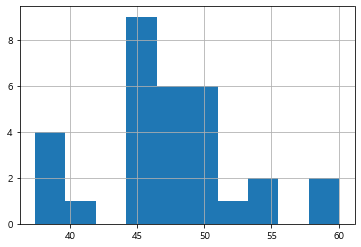

In [30]:
# pandas의 DataFrame.hist method 이용 : OXY에 대한 히스토그램 생성
df_fitness["OXY"].hist()

> 자료는 (45~50) 구간에 집중 분포되어 있으며 데이터 섬(island)이 확인됨

array([[<AxesSubplot:title={'center':'AGE'}>,
        <AxesSubplot:title={'center':'WEIGHT'}>,
        <AxesSubplot:title={'center':'OXY'}>],
       [<AxesSubplot:title={'center':'RUNTIME'}>,
        <AxesSubplot:title={'center':'RUNPULSE'}>,
        <AxesSubplot:title={'center':'RSTPULSE'}>],
       [<AxesSubplot:title={'center':'MAXPULSE'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

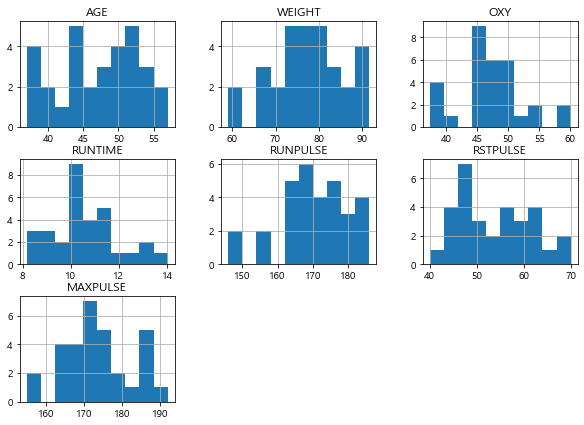

In [31]:
# hist(figsiz) : figsize=(x축 크기, y축 크기) - 그래프 영역별 중첩 처리
df_fitness.hist(figsize=(10, 7))

> __다수의 숫자형 변수 분포를 동시에 확인__

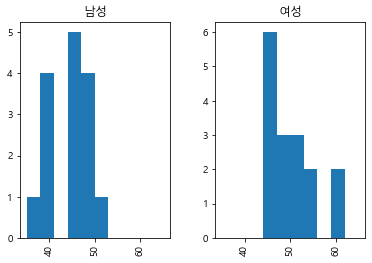

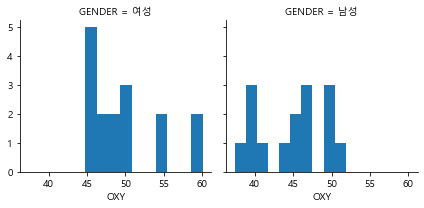

In [32]:
# hist(column=변수, by = 그룹변수, range = (최소값, 최대값)) - x축 범위 통일
df_fitness.hist(column="OXY", by="GENDER", range=(35, 65))
# seaborn 사용. FacetGRid(데이터 지정, col=컬럼 지정) : 지정된 컬럼의 범주별 그리드 영역 생성.
# Y축 범위 동일
grid=sns.FacetGrid(df_fitness, col="GENDER")
# map(함수, 문자형 칼럼명) : 범주형 히스토그램 생성
grid.map(plt.hist, "OXY")

> 남성 자료는 (37 ~ 52)의 낮은 구간에, 여성 자료는 (45 ~ 60)의 높은 구간에 분포되어 있음

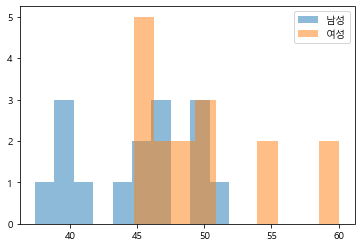

In [33]:
# matplotlib.pyplot.his method 이용하여 중첩 histogram 생성
# hist(변수, label="표시 값", alpha=투명도(0~1 지정))
plt.hist(df_fitness[df_fitness["GENDER"]=="남성"]["OXY"], label="남성", alpha=0.5)
plt.hist(df_fitness[df_fitness["GENDER"]=="여성"]["OXY"], label="여성", alpha=0.5)
plt.legend()

> __남성은 낮은 수준에, 여성은 높은 수준에 분푀되어 있음__

(array([4., 1., 0., 9., 6., 6., 1., 2., 0., 2.]),
 array([37.388 , 39.6547, 41.9214, 44.1881, 46.4548, 48.7215, 50.9882,
        53.2549, 55.5216, 57.7883, 60.055 ]),
 <BarContainer object of 10 artists>)

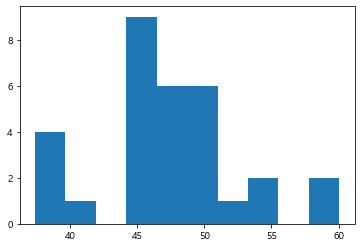

In [34]:
# hist(변수, data)
plt.hist(x="OXY", data=df_fitness)



(array([1., 0., 3., 0., 1., 0., 0., 0., 0., 3., 4., 2., 2., 3., 1., 2., 1.,
        3., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2.]),
 array([37.388     , 38.14356667, 38.89913333, 39.6547    , 40.41026667,
        41.16583333, 41.9214    , 42.67696667, 43.43253333, 44.1881    ,
        44.94366667, 45.69923333, 46.4548    , 47.21036667, 47.96593333,
        48.7215    , 49.47706667, 50.23263333, 50.9882    , 51.74376667,
        52.49933333, 53.2549    , 54.01046667, 54.76603333, 55.5216    ,
        56.27716667, 57.03273333, 57.7883    , 58.54386667, 59.29943333,
        60.055     ]),
 <BarContainer object of 30 artists>)

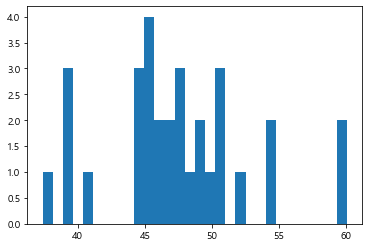

In [35]:
# x축 구간(bin) 조정(상세 분포 확인)
plt.hist(x="OXY", data=df_fitness, bins=30)

> __상세한 분포 확인 가능__

### 4. Box Plot
아래는 운동에 따른 혈당 산소 요구량 데이터이다.  
성별(GENDER)+연령대(AGEGROUP) 혈당 산소 요구량(OXY)의 분포 및 이상치 포함 여부를 Box Plot으로 그리고,  
결과를 해석하시오.
- 데이터 : FITNESS.CSV(변수 : 10개, 자료 수 : 31개)

<AxesSubplot:title={'center':'OXY'}, xlabel='[GENDER, AGEGROUP]'>

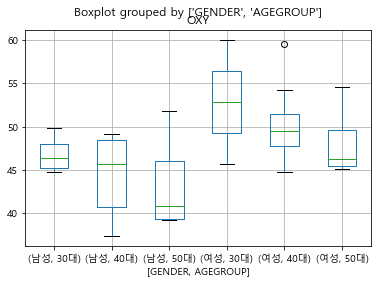

In [36]:
# boxplot(column=변수, by=그룹 변수)
df_fitness.boxplot(column="OXY", by=["GENDER", "AGEGROUP"])

> __여성이 남성보다 수준이 높고 또한 연령대가 증가할수록 수준이 낮아지는 경향이 있음__

### 5. Pie Chart
아래는 운동에 따른 혈당 산소 요구량 데이터이다.  
성별(GENDER)+연령대(AGEGROUP) 자료 수를 Pie Chart으로 그리고, 결과를 해석하시오.
- 데이터 : FITNESS.CSV(변수 : 10개, 자료 수 : 31개)

<AxesSubplot:ylabel='None'>

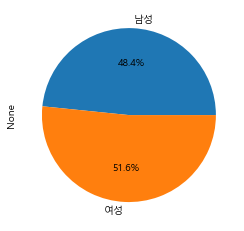

In [37]:
# 성별 Pie Chart
# groupby(column):column 기준 자료 요약.(size : group별 자료수)
df_count=df_fitness.groupby(["GENDER"]).size()
# pie(데이터, labels=레이블 변수 지정, autopct=비율 %로 표시(%.1f%%:소수점 1자리 적용))
df_count.plot.pie(y="OXY", autopct="%.1f%%")

> __남성과 여성은 비율이 비슷함__

<AxesSubplot:ylabel='None'>

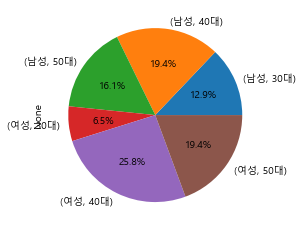

In [38]:
# 성별 + 연령대 Pie Chart
# groupby(column) : column 기준 자료 요약.(size : group별 자료수)
df_count=df_fitness.groupby(["GENDER", "AGEGROUP"]).size()
# pie(데이터, labels=레이블 변수 지정, autopct=비율 %로 표시(%.1f%% : 소수점 1자리 적용))
df_count.plot.pie(y="OXY", autopct="%.1f%%")

> __(여성, 40대) 비율이 25.8%로 가장 높고__  
> __(여성, 30대) 비율이 가장 낮음__

### 6. Scatter Plot
아래는 운동에 따른 혈당 산소 요구량 데이터이다.  
성별(GENDER), 운동시간(RUNTIME)과 혈당 산소요구량(OXY) 간의 관계를 Scatter Plot으로 생성하고, 결과를 해석하시오.
- 데이터 : FITNESS.CSV(변수 : 10개, 자료 수 : 31개)

<AxesSubplot:xlabel='RUNTIME', ylabel='OXY'>

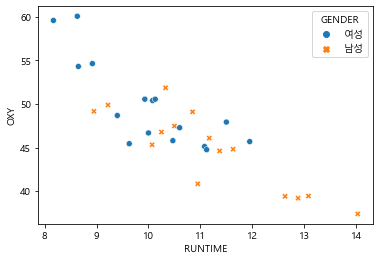

In [39]:
# seaborn.scatterplot method 이용
# scatterplot(x, y, hue: 그룹 변수, style : 그룹별 marker 구분, data)
sns.scatterplot(x="RUNTIME", y="OXY", hue="GENDER", style="GENDER", data=df_fitness)

> __운동시간이 증가하면서 혈당 산소 요구량은 감소하고 있는 패턴을 확인할 수 있고  
> 이 추세는 성별 구분 없이 동일하게 나타남__

### 7. Scatter Matrix
아래는 운동에 따른 혈당 산소 요구량 데이터이다.  
전체 연속형 변수 또는 혈당산소 요구량(OXY)에 대한 맥박(운동)(RUNPULSE), 맥박(최대) (MAXPULSE), 운동시간(RUNTIME) 간의 관계를 Scatter Matrix로 생성하고 결과를 해석하시오.
- 데이터 : FITNESS.CSV(변수 : 10개, 자료 수 : 31개)

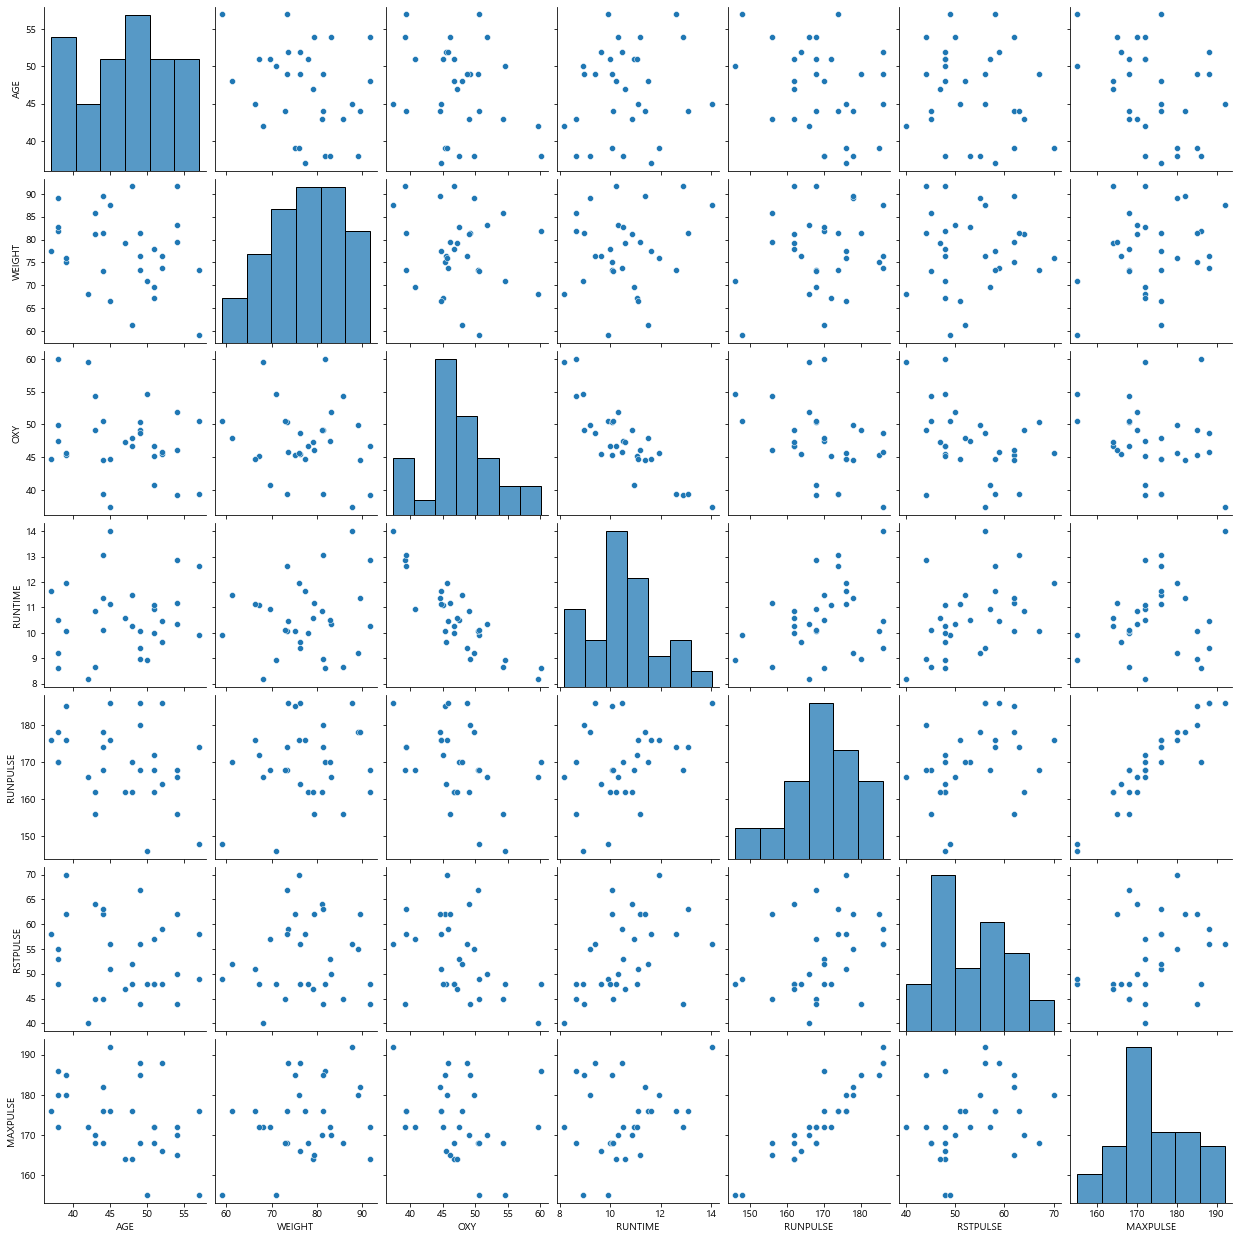

In [40]:
# 전체 변수 간의 관계 Scatter Matrix 생성
# pairplot(데이터) : Scatter Plot 그래프 생성
sns.pairplot(df_fitness)

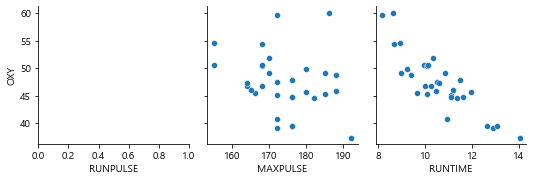

In [41]:
# y변수 : 혈당산소 요구량, x변수 : 맥박(운동), 맥박(최대), 운동시간 Scatter Matrix 생성
# pairplot(데이터, y_vars = y축 변수, x_vars=x축 변수): Scatter Plot 그래프 생성
sns.pairplot(df_fitness, y_vars=["OXY"], x_vars=["RUNPULSE", "MAXPULSE", "RUNTIME"])

> __맥박(운동)과 맥박(최대) 등 변수 간의 선형 관계를 확인할 수 있고__   
> __혈당 산소 요구량은 운동시간과 반비례 관계가 있음__

In [42]:
# 환율.CSV 데이터 가져오기.
# 파일 이름에 한글 포함되어 있는 경우 engine ="python" 지정, parse_data:날짜 변수 지정
df_currency=pd.read_csv("../data/환율.CSV", engine="python", parse_dates=["APPL_DATE"])
df_currency.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


### 8. Trend Chart
아래는 중국 위엔화(CNY), 일본 엔화(JPY) 그리고 미국 달러(USD)의 환율 데이터이다.  
통화(CURRENCY)별로 월별 매매 기준율(STD_RATE)의 변화를 Trend Chart로 생성하고 결과를 해석하시오.
- 데이터 : 환율.CSV(변수 : 4개, 자료 수 : 273개, 기간 : 20160101~20160331)

In [43]:
# Pivot 활용하여 각국 통화별 데이터 생성
df_currency_pivot=df_currency.pivot(index="APPL_DATE", columns="CURRENCY", values="STD_RATE")
df_currency_pivot.head()

CURRENCY,CNY,JPY,USD
APPL_DATE,,,
2016-01-01,181.48,976.99,1178.0
2016-01-02,181.48,976.99,1178.0
2016-01-03,181.48,976.99,1178.0
2016-01-04,181.10,992.62,1184.0
2016-01-05,181.94,993.00,1185.0


<AxesSubplot:xlabel='APPL_DATE'>

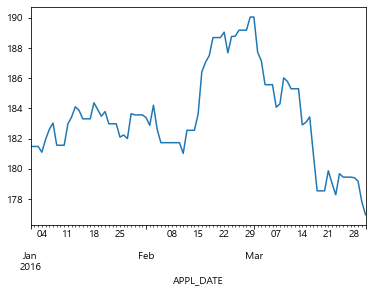

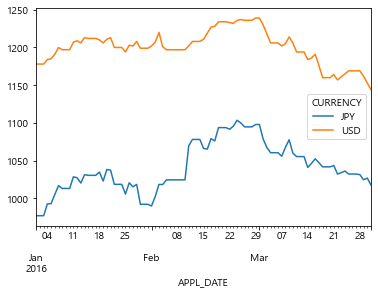

In [44]:
# 중국 위안화 별도 그림(엔화, 달러와 단위 차이)
df_currency_pivot["CNY"].plot()
# 일본 엔화, 미국 달러
df_currency_pivot[["JPY", "USD"]].plot()

> __엔화와 달러는 비슷한 변화 패턴을 보이나 위안화는 추세가 다름__

### 9. Heatmap
아래는 운동에 따른 혈당 산소 요구량 데이터이다.  
성별(GENDER) 연령대(AGEGROUP)별 혈당 산소 요구량(OXY) 현황을 Heatmap을 생성하고 결과를 해석하시오.
- 데이터 : FITNESS.CSV(변수 : 10개, 자료 수 : 31개)

<AxesSubplot:xlabel='AGEGROUP', ylabel='GENDER'>

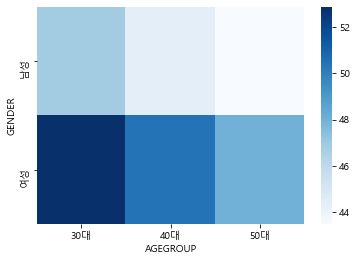

In [45]:
# 성별과 연령대별 혈당 산소 요구량 평균 계산, groupby:(성별, 연령), agg("mean") : 혈당 산소 요구량 평균값
df_agg=df_fitness.groupby(["GENDER", "AGEGROUP"], as_index=False).agg("mean")
# pivot(성별, 연령대, 혈당 산소 요구량) : x축(연령대), y축(성별), 값(혈당산소요구량의 평균)으로 pivot
df_pivot=df_agg.pivot("GENDER", "AGEGROUP", "OXY")
# heatmap(데이터, cmap:색상)
sns.heatmap(df_pivot, cmap="Blues")

In [46]:
df_pivot

AGEGROUP,30대,40대,50대
GENDER,,,
남성,46.86625,44.410000,43.476200
여성,52.86800,50.427125,48.031833


> __여성, 남성 모두 연령대가 낮을수록 혈당 산소 요구량이 높으며, 그 평균 수준은 여성이 남성보다 높음__

### 10. Contour Plot
아래는 운동에 따른 혈당 산소 요구량 데이터이다.  
운동시간(RUNTIME)과 혈당 산소 요구량(OXY)으로 Contour Plot을 생성하고 결과를 해석하시오.
- 데이터 : FITNESS.CSV(변수 : 10개, 자료 수 : 31개)

C:\Users\82105\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='RUNTIME', ylabel='OXY'>

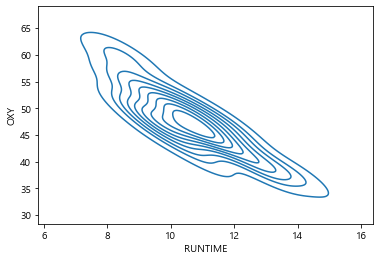

In [47]:
# kdeplot(x축, y축, shade: 음영 선택 여부)
sns.kdeplot(df_fitness["RUNTIME"], df_fitness["OXY"], shade=False)
# 파이썬에서는 X,Y축 값에 따른 밀도 수준을 표현

C:\Users\82105\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='RUNTIME', ylabel='OXY'>

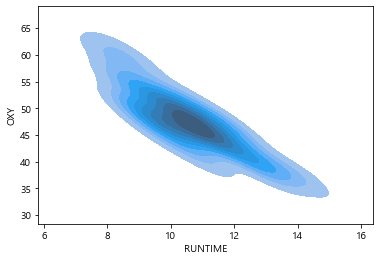

In [48]:
sns.kdeplot(df_fitness["RUNTIME"], df_fitness["OXY"], shade=True)

> __혈당 산소 요구량은 (45~50), 운동시간은 (10~12) 범우에 많이 분포되어 있음__

### 11. Parallel Plot
아래는 운동에 따른 혈당 산소 요구량 데이터이다.  
성별(GENDER)에 따른 혈당 산소 요구량(OXY), 몸무게(WEIGHT), 휴식 시 맥박수(RSTPULSE)의 관계를   
Parallel Plot을 생성하고 결과를 해석하시오.
- 데이터 : FITNESS.CSV(변수 : 10개, 자료 수 : 31개)

<AxesSubplot:>

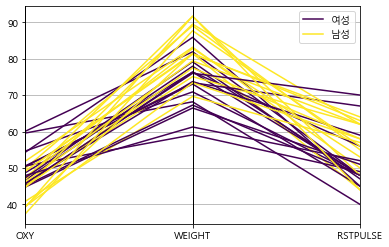

In [49]:
# parallel_coordinates(데이터, 그룹 변수, cols=변수, colormap=다양한 colormap 지정)
pd.plotting.parallel_coordinates(df_fitness, "GENDER", cols=["OXY", "WEIGHT", "RSTPULSE"], colormap="viridis")

> __남성은 여성에 비해 몸무게, 휴식 시 맥박수는 높은 수준이지만 혈당 산소 요구량은 반대로 낮은 수준임__

### 12. Customizing
아래는 운동에 따른 혈당 산소 요구량 데이터이다.  
Histogram, Pie Chart, Trend Chart, Scatter Plot을 이용한 Dashboard를 생성하시오.
- 데이터 : FITNESS.CSV(변수 : 10개, 자료 수 : 31개)

Text(488.4227272727271, 0.5, '혈당 산소 요구량')

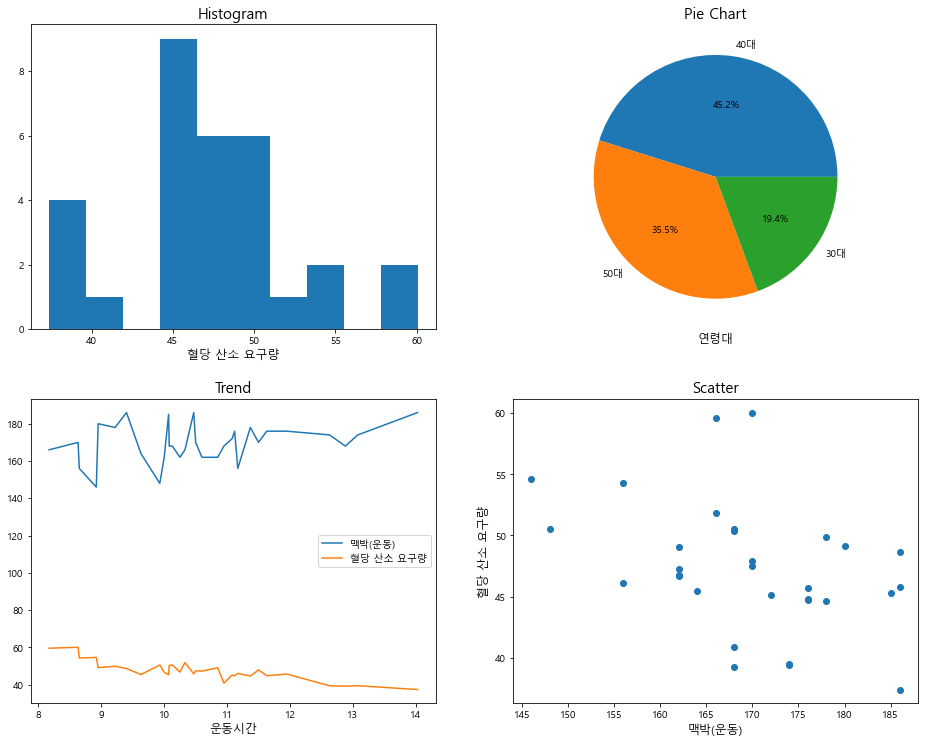

In [50]:
df_count=df_fitness["AGEGROUP"].value_counts()               # Pie Chart를 위한 집계 데이터
fig, axes=plt.subplots(nrows=2, ncols=2, figsize=(13, 10))  # (2, 2) 4분할, 4개의 그래프 생성
plt.tight_layout(w_pad=5, h_pad=5)                         # w_pad: 열 사이 간격, h_pad: 행 사이 간격

# Histogram
axes[0, 0].hist(df_fitness["OXY"])                         # [0, 0] 위치에 Histogram 생성
axes[0, 0].set_title("Histogram", fontsize=15)             # 제목 설정, 글자 크기 15
axes[0, 0].set_xlabel("혈당 산소 요구량", fontsize=12)     # x축 label 지정

# Pie Chart
axes[0, 1].pie(df_count, labels=df_count.index.tolist(), autopct="%.1f%%") # [0, 1] 위치에 Pie Chart 생성
axes[0, 1].set_title("Pie Chart", fontsize=15)
axes[0, 1].set_xlabel("연령대", fontsize=12) 

# Trend
axes[1, 0].plot("RUNTIME", "RUNPULSE", data=df_fitness, label="맥박(운동)")# [1, 0] x축: 운동 시간, y축: 맥박(운동)
axes[1, 0].plot("RUNTIME", "OXY", data=df_fitness, label="혈당 산소 요구량")
axes[1, 0].set_title("Trend", fontsize=15)
axes[1, 0].set_xlabel("운동시간", fontsize=12)
axes[1, 0].legend()   # 범례 표시

# Scatter
axes[1, 1].scatter("RUNPULSE", "OXY", data=df_fitness)  # [1, 1] 위치에 산점도 표시, x축: 맥박(운동), y축: 산소 요구량
axes[1, 1].set_title("Scatter", fontsize=15)
axes[1, 1].set_xlabel("맥박(운동)", fontsize=12)
axes[1, 1].set_ylabel("혈당 산소 요구량", fontsize=12)

> __다양한 종류의그래프를 customizing 하고 동시에 비교하여 분석할 수 있는 Dashboard 생성__

# 실습_탐색적 분석

데이터 분석 모델링 전에 데이터를 이해하고 분석방향을 설정하기 위해 탐색적 분석을 실시하시오.
- 데이터 셋 : Titanic.CSV(변수:12, 자료 수: 891개)
- 종속변수 : Survived(생존여부) - Survival(0=No, 1=Yes)
> - Pclass: 승객 등급. 1, 2, 3등석
> - Name, Sex, Age : 이름 그대로 의미입니다.
> - Sibsp : 함께 탑승한 형제, 배우자의 수.
> - Parch : 함께 탑승한 자녀, 부모의 수.
> - Ticket : 티켓 아이디
> - Fare : 티켓 요금(파운드)
> - Cabin : 객실 번호
> - Embarked : 승객이 탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southampton)

In [51]:
data=pd.read_csv("../data/Titanic.csv", engine='python')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [52]:
# 데이터 속성 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [53]:
# 기술통계량 확인
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.758889,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002570,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [54]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64